**libraries**

In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
import cv2

**Phase 1**

Features saved successfully as 'mnist_features.pkl'.
Images for visualization saved successfully as 'mnist_visualized_images.pkl'.


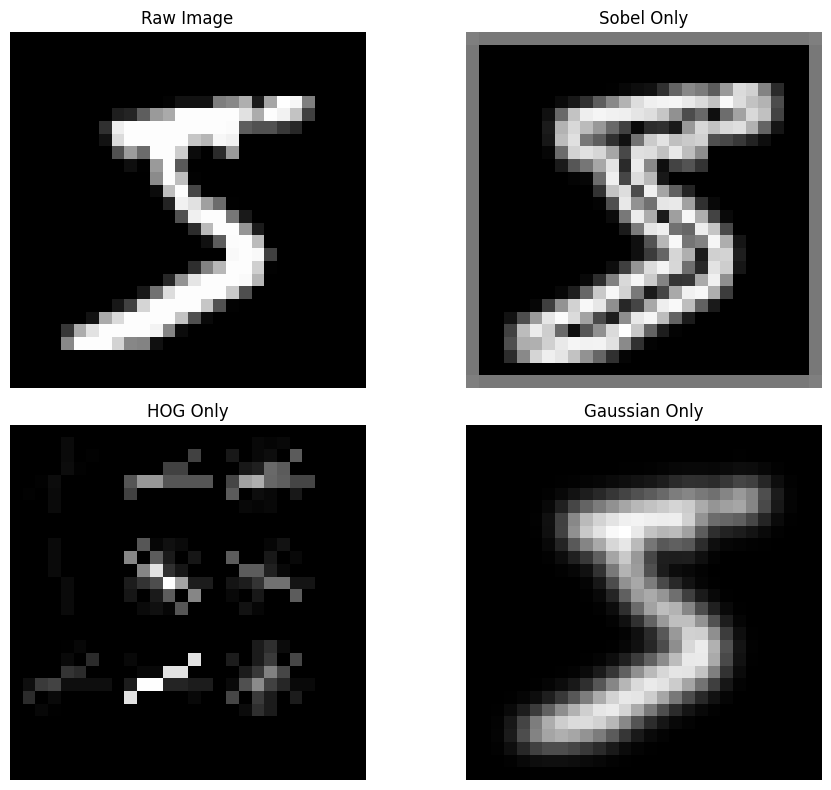

In [ ]:
# Define transformations to convert MNIST data to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to the range [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Create a DataLoader for the full dataset
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=1, shuffle=False)

#Sobel filter kernels
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)  # Horizontal edges
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)   # Vertical edges

# Custom convolution
def custom_convolution(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_h, pad_w = kernel_height // 2, kernel_width // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)

    for i in range(image_height):
        for j in range(image_width):
            output[i, j] = np.sum(padded_image[i:i + kernel_height, j:j + kernel_width] * kernel)
    return output

# Dictionary to store features for all filters
features_data = {
    'raw': [],
    'sobel_only': [],
    'hog_only': [],
    'gaussian_only': [],
    'sobel_hog': [],
    'gaussian_hog': [],
}
labels = []

# Dictionary to store images for plotting
visualized_images = {
    'raw': [],
    'sobel_only': [],
    'hog_only': [],
    'gaussian_only': [],
}

for i, (image_tensor, label) in enumerate(full_loader):
    image = image_tensor[0][0].numpy() * 255  # Convert to numpy and scale to [0, 255]
    labels.append(label.item())

    # 1.Raw Image
    features_data['raw'].append(image.flatten())  # Save flattened raw image as feature
    visualized_images['raw'].append(image)  # Save for visualization

    # 2.Sobel Only
    sobel_x_img = custom_convolution(image, sobel_x)
    sobel_y_img = custom_convolution(image, sobel_y)
    sobel_combined = np.sqrt(sobel_x_img**2 + sobel_y_img**2)  # Edge magnitude
    features_data['sobel_only'].append(sobel_combined.flatten())  # Save Sobel feature
    visualized_images['sobel_only'].append(sobel_combined)  # Save for visualization

    # 3.HOG Only
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                  orientations=9, visualize=True, block_norm='L2-Hys', feature_vector=True)
    features_data['hog_only'].append(hog_features)  # Save HOG feature
    visualized_images['hog_only'].append(hog_image)  # Save for visualization

    # 4.Gaussian Only
    gaussian_filtered = gaussian_filter(image, sigma=1)  # Apply Gaussian filter
    features_data['gaussian_only'].append(gaussian_filtered.flatten())  # Save Gaussian feature
    visualized_images['gaussian_only'].append(gaussian_filtered)  # Save for visualization

    # 5.Sobel + HOG
    sobel_hog_combined = np.concatenate((sobel_combined.flatten(), hog_features))
    features_data['sobel_hog'].append(sobel_hog_combined)

    # 6.Gaussian + HOG
    gaussian_hog_combined = np.concatenate((gaussian_filtered.flatten(), hog_features))
    features_data['gaussian_hog'].append(gaussian_hog_combined)

    # if i >= 99:
    #     break

# Convert lists to numpy arrays for easier handling
for key in features_data:
    features_data[key] = np.array(features_data[key])
labels = np.array(labels)

# Save features and labels to a Pickle file
with open('mnist_features.pkl', 'wb') as f:
    pickle.dump({'features_data': features_data, 'labels': labels}, f)

print("Features saved successfully as 'mnist_features.pkl'.")

with open('mnist_visualized_images.pkl', 'wb') as f:
    pickle.dump(visualized_images, f)

print("Images for visualization saved successfully as 'mnist_visualized_images.pkl'.")

# Visualization
index = 0
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Raw Image
axs[0][0].imshow(visualized_images['raw'][index], cmap='gray')
axs[0][0].set_title("Raw Image")
axs[0][0].axis('off')

# Sobel Only
axs[0][1].imshow(visualized_images['sobel_only'][index], cmap='gray')
axs[0][1].set_title("Sobel Only")
axs[0][1].axis('off')

# HOG Only
axs[1][0].imshow(visualized_images['hog_only'][index], cmap='gray')
axs[1][0].set_title("HOG Only")
axs[1][0].axis('off')

# Gaussian Only
axs[1][1].imshow(visualized_images['gaussian_only'][index], cmap='gray')
axs[1][1].set_title("Gaussian Only")
axs[1][1].axis('off')

plt.tight_layout()
plt.show()

**Phase 2**


Processing dataset with raw...


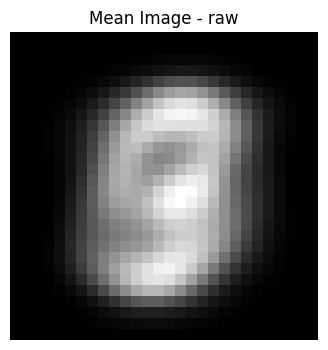

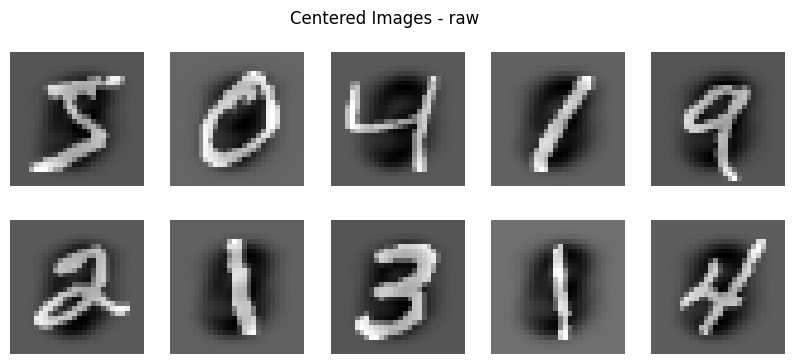

Optimal number of components based on diminishing returns and minimum variance threshold: 43


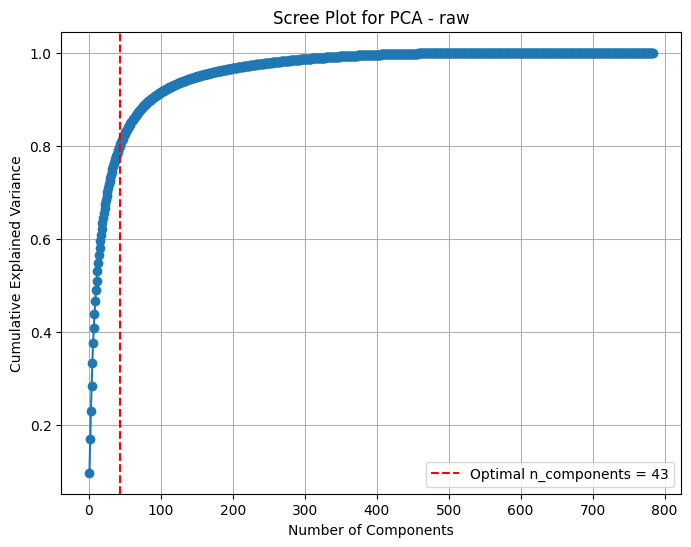


Processing dataset with sobel_hog...
Optimal number of components based on diminishing returns and minimum variance threshold: 90


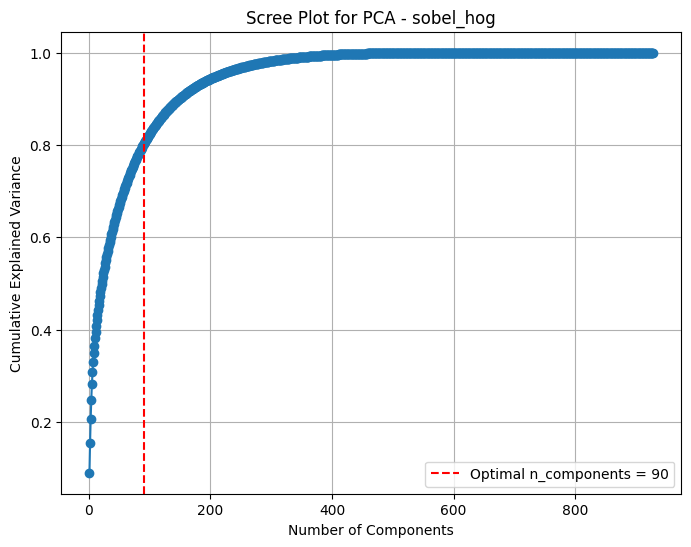


Train-test splits saved to 'train_test_splits.pkl'.


In [ ]:
with open('mnist_features.pkl', 'rb') as f:
    data = pickle.load(f)

filtered_data = data['features_data']  # Access the features for all filters
labels = data['labels']  # Access the labels

selected_filters = ['raw', 'sobel_hog']

# Initialize a dictionary to store train-test splits for selected filters
train_test_splits = {}

for filter_name in selected_filters:
    print(f"\nProcessing dataset with {filter_name}...")

    # Get the filtered images/features for the current filter
    filtered_features = filtered_data[filter_name]

    # Center the features by subtracting the mean
    mean_feature = np.mean(filtered_features, axis=0)
    centered_features = filtered_features - mean_feature

    if filter_name == 'raw':
        # Visualize the mean image if the filter is "raw"
        target_shape = (28, 28)  # Raw images should match this shape
        plt.figure(figsize=(4, 4))
        plt.title(f"Mean Image - {filter_name}")
        plt.imshow(mean_feature.reshape(target_shape), cmap='gray')
        plt.axis('off')
        plt.show()
        
        # Display a few centered images to see the effect of centering
        fig, axs = plt.subplots(2, 5, figsize=(10, 4))
        fig.suptitle(f"Centered Images - {filter_name}")
        for i in range(10):
            ax = axs[i // 5, i % 5]
            ax.imshow(centered_features[i].reshape(target_shape), cmap='gray')
            ax.axis('off')
        plt.show()

    # Apply PCA and dynamically determine the optimal n_components
    pca = PCA()
    pca.fit(centered_features)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    variance_diffs = np.diff(explained_variance)

    # Set a threshold for detecting diminishing returns (e.g., less than 0.01 additional variance)
    diminishing_threshold = 0.01
    optimal_n_components = np.argmax(variance_diffs < diminishing_threshold) + 1

    # Ensure that the selected number of components explains at least a minimum variance (e.g., 80%)
    min_variance_threshold = 0.8
    if explained_variance[optimal_n_components - 1] < min_variance_threshold:
        optimal_n_components = np.argmax(explained_variance >= min_variance_threshold) + 1

    print(f"Optimal number of components based on diminishing returns and minimum variance threshold: {optimal_n_components}")

    # Plot the scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Scree Plot for PCA - {filter_name}')
    plt.axvline(optimal_n_components, color='r', linestyle='--', label=f"Optimal n_components = {optimal_n_components}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Apply PCA with the dynamically selected number of components
    pca = PCA(n_components=optimal_n_components)
    reduced_features = pca.fit_transform(centered_features)

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, random_state=42)

    # Store the split in the dictionary
    train_test_splits[filter_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

with open('train_test_splits.pkl', 'wb') as f:
    pickle.dump(train_test_splits, f)

print("\nTrain-test splits saved to 'train_test_splits.pkl'.")


**Phase 3**

Processing additional dataset: sobel_only...
Processing additional dataset: gaussian_hog...

Additional datasets processed and added to train_test_splits.

Performing grid search for raw...
Best parameters for raw: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 8}
Test accuracy for best raw Decision Tree: 0.8560

Performing grid search for sobel_hog...
Best parameters for sobel_hog: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2}
Test accuracy for best sobel_hog Decision Tree: 0.8224

Performing grid search for sobel_only...
Best parameters for sobel_only: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 11}
Test accuracy for best sobel_only Decision Tree: 0.8539

Performing grid search for gaussian_hog...
Best parameters for gaussian_hog: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}
Test accuracy for best gaussian_hog Decisio

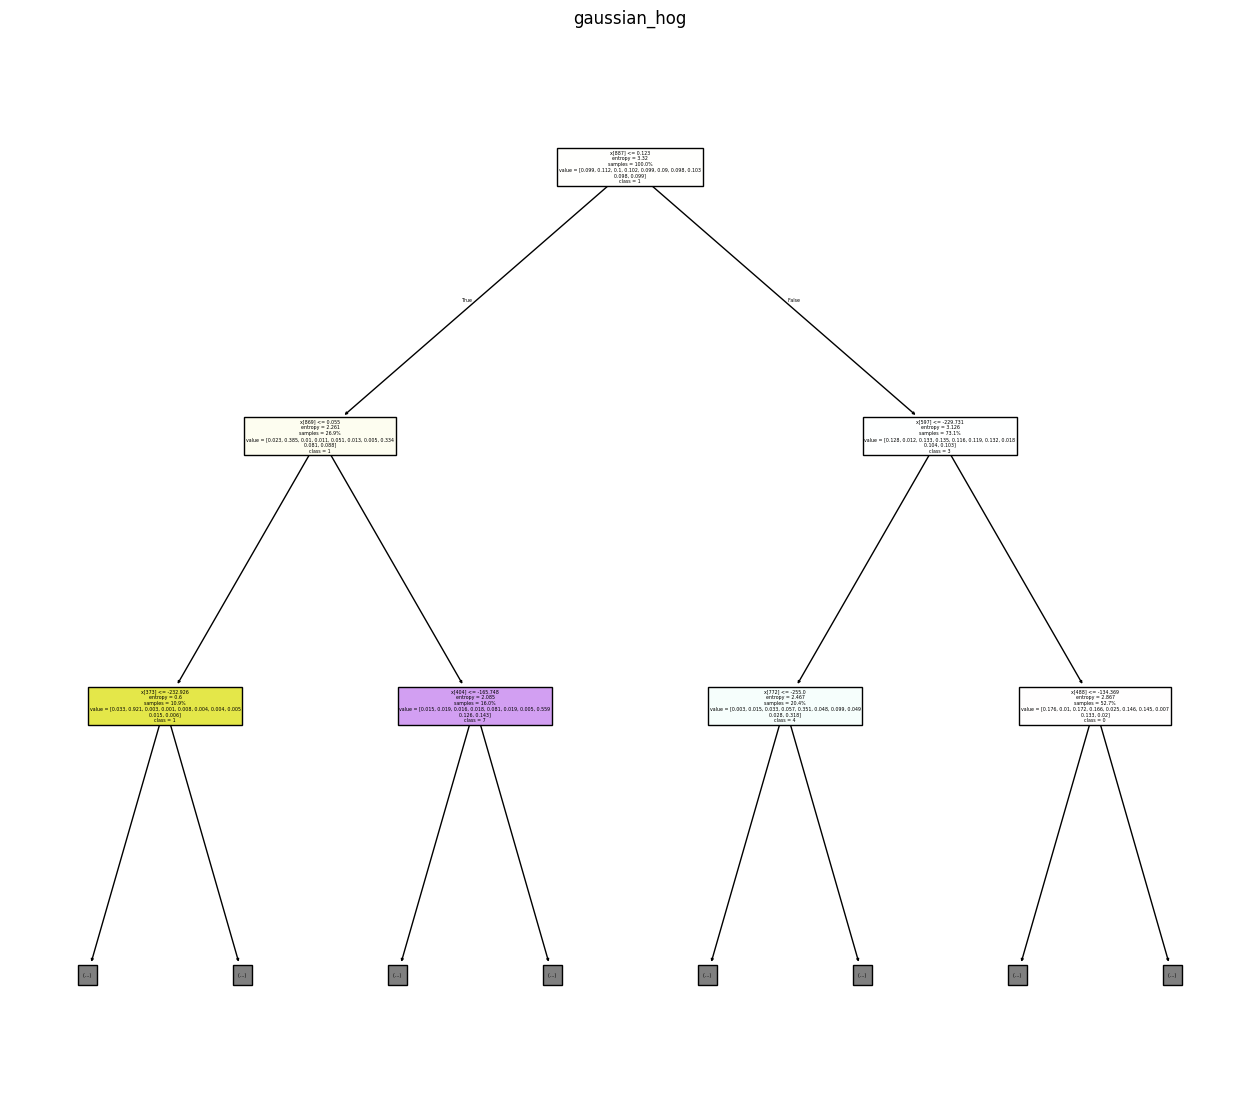

In [ ]:
with open('train_test_splits.pkl', 'rb') as f:
    train_test_splits = pickle.load(f)

with open('mnist_features.pkl', 'rb') as f:
    mnist_data = pickle.load(f)

filtered_data = mnist_data['features_data']  # Access features
labels = mnist_data['labels']  # Access labels

# Add sobel_only and gaussian_hog to train_test_splits
additional_filters = ['sobel_only', 'gaussian_hog']
for filter_name in additional_filters:
    print(f"Processing additional dataset: {filter_name}...")

    # Retrieve features for the filter
    filtered_features = np.array(filtered_data[filter_name])

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        filtered_features, labels, test_size=0.2, random_state=42
    )

    # Store train-test splits
    train_test_splits[filter_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

print("\nAdditional datasets processed and added to train_test_splits.")

# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [8, 10, 15],
    'min_samples_split': [2, 8, 9, 11],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize dictionaries to store models and accuracies
best_decision_tree_models = {}
best_accuracies = {}

# GridSearch for DTs
for filter_name in ["raw", "sobel_hog", "sobel_only", "gaussian_hog"]:
    print(f"\nPerforming grid search for {filter_name}...")

    # Extract train and test data
    split_data = train_test_splits[filter_name]
    X_train, X_test = split_data['X_train'], split_data['X_test']
    y_train, y_test = split_data['y_train'], split_data['y_test']

    # Initialize a Decision Tree and use GridSearchCV
    dt_model = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model and evaluate it on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_decision_tree_models[filter_name] = best_model
    best_accuracies[filter_name] = accuracy
    print(f"Best parameters for {filter_name}: {grid_search.best_params_}")
    print(f"Test accuracy for best {filter_name} Decision Tree: {accuracy:.4f}")

#saving DT model
for filter_name in ['sobel_hog']:
    if filter_name in best_decision_tree_models:
        model = best_decision_tree_models[filter_name]
        with open(f'{filter_name}_decision_tree_model.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f"{filter_name} Decision Tree model saved successfully!")

# SVMs 
svm_accuracies = {}

for filter_name in ["raw", "sobel_hog"]:  # SVM only on these filters
    print(f"\nPerforming SVM on {filter_name}...")

    # Extract train and test data
    split_data = train_test_splits[filter_name]
    X_train, X_test = split_data['X_train'], split_data['X_test']
    y_train, y_test = split_data['y_train'], split_data['y_test']

    # Initialize and fit the SVM model
    svm_model = SVC(kernel='rbf', C=1, gamma='scale')
    # svm_model = SVC(kernel='rbf', C=0.1, gamma=0.01)
    # svm_model = SVC(kernel='rbf', C=10, gamma=1)
    svm_model.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred_svm = svm_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    svm_accuracies[filter_name] = svm_accuracy
    print(f"SVM Test accuracy for {filter_name}: {svm_accuracy:.4f}")

# Compare DTs
best_filter_name = max(best_accuracies, key=best_accuracies.get)
print(f"\nBest Decision Tree model is from {best_filter_name} filter with accuracy: {best_accuracies[best_filter_name]:.4f}")

# Plotting the best decision tree
def plot_tree_model(model, title, max_depth=None):
    plt.figure(figsize=(16, 14))
    plot_tree(
        model,
        filled=True,
        max_depth=max_depth,  # Option to restrict the visible depth
        feature_names=None,
        class_names=[str(i) for i in range(10)],
        proportion=True
    )
    plt.title(title)
    plt.show()

# Plot the best Decision Tree
plot_tree_model(best_decision_tree_models[best_filter_name], best_filter_name, 2)


**Phase 4**

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1343
           1       0.95      0.95      0.95      1600
           2       0.82      0.81      0.82      1380
           3       0.74      0.72      0.73      1433
           4       0.79      0.81      0.80      1295
           5       0.75      0.75      0.75      1273
           6       0.91      0.92      0.91      1396
           7       0.88      0.83      0.85      1503
           8       0.74      0.73      0.74      1357
           9       0.77      0.78      0.77      1420

    accuracy                           0.82     14000
   macro avg       0.82      0.82      0.82     14000
weighted avg       0.82      0.82      0.82     14000



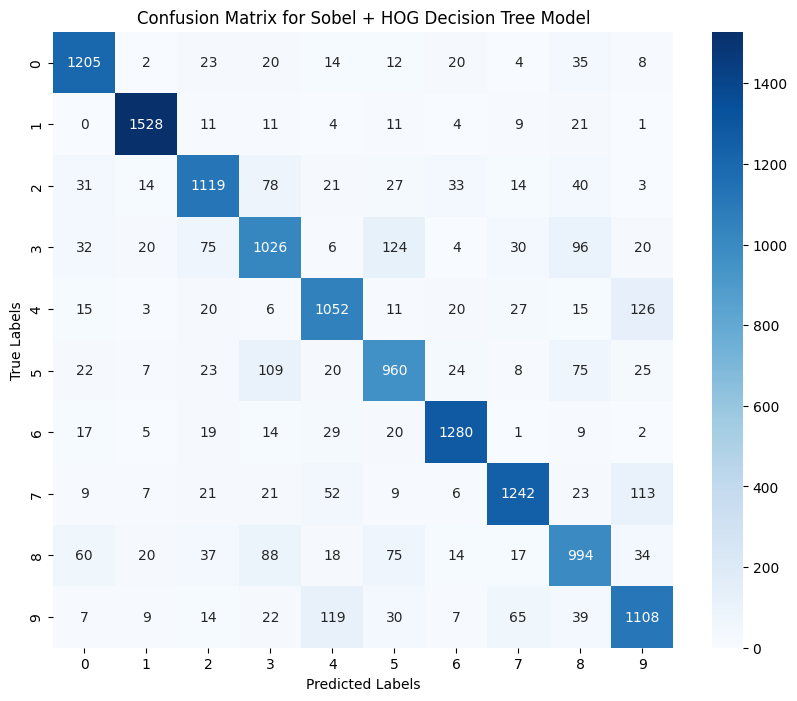

In [ ]:
with open('train_test_splits.pkl', 'rb') as f:
    train_test_splits = pickle.load(f)

best_filter_name = 'sobel_hog'
split_data = train_test_splits[best_filter_name]

X_train, X_test = split_data['X_train'], split_data['X_test']
y_train, y_test = split_data['y_train'], split_data['y_test']

# Load the best DT model from Phase 3
with open('sobel_hog_decision_tree_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Evaluate the model directly on the test set
y_pred = best_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for Sobel + HOG Decision Tree Model")
plt.show()


**Phase 5**

In [ ]:
with open('train_test_splits.pkl', 'rb') as file:
    train_test_splits = pickle.load(file)

with open('sobel_hog_decision_tree_model.pkl', 'rb') as file:
    sobel_hog_decision_tree = pickle.load(file)

# Extract Sobel + HOG data splits
best_filter_name = 'sobel_hog'
split_data = train_test_splits[best_filter_name]

X_train, X_test = split_data['X_train'], split_data['X_test']
y_train, y_test = split_data['y_train'], split_data['y_test']

# Phase 1: Build an Overfitting Decision Tree (No pre-pruning)
overfitting_tree = DecisionTreeClassifier(random_state=42)
overfitting_tree.fit(X_train, y_train)

# Make predictions and calculate accuracy on the test set
y_pred_overfit = overfitting_tree.predict(X_test)
accuracy_overfit = accuracy_score(y_test, y_pred_overfit)

print(f"Accuracy of overfitting tree: {accuracy_overfit:.4f}")
print(f"Overfitting tree depth: {overfitting_tree.get_depth()}")

# Apply Pre-Pruning
pruned_tree = DecisionTreeClassifier(max_depth=14,min_samples_leaf=10,  min_samples_split=2)
pruned_tree.fit(X_train, y_train)

# Make predictions and calculate accuracy on the test set
y_pred_pruned = pruned_tree.predict(X_test)
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)

print(f"Accuracy of pruned tree: {accuracy_pruned:.4f}")
print(f"Pruned tree depth: {pruned_tree.get_depth()}")

# Compare the pre-pruned tree with the previously saved Sobel + HOG model
y_pred_saved_model = sobel_hog_decision_tree.predict(X_test)
accuracy_saved_model = accuracy_score(y_test, y_pred_saved_model)

print(f"Accuracy of saved Sobel + HOG Decision Tree model: {accuracy_saved_model:.4f}")
print(f"Saved Sobel + HOG Decision Tree depth: {sobel_hog_decision_tree.get_depth()}")

# Plotting the trees with larger figures and better formatting
def plot_tree_model(model, title, max_depth=None):
    plt.figure(figsize=(16, 12))
    plot_tree(
        model, 
        filled=True, 
        max_depth=max_depth,  # Option to restrict the visible depth
        feature_names=None, 
        class_names=[str(i) for i in range(10)], 
        proportion=True
    )
    plt.title(title)
    plt.show()

# # Plot the trees
print("\nPlotting Overfitting Decision Tree (full depth)")
plot_tree_model(overfitting_tree, title="Overfitting Decision Tree")  # Limit depth for clarity

print("\nPlotting Pre-Pruned Decision Tree (max depth = 14)")
plot_tree_model(pruned_tree, title="Pre-Pruned Decision Tree")

print("\nPlotting Saved Sobel + HOG Decision Tree")
plot_tree_model(sobel_hog_decision_tree, title="Saved Sobel + HOG Decision Tree (from Phase 3)")

